In [56]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
tweetData = pd.read_csv('featureEngineeredFinal.csv', index_col=False)
tweetData

,Unnamed: 0,Unnamed: 0.1,tweet,tweettype,charCount,wordCount,sentenceCount,capCharCount,capWordCount,quotedWordCount,...,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,lemmatizedText
0,0,0,@ZubairSabirPTI pls dont insult the word 'Molna',anger,49,7,1,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pls dont insult word
1,1,1,@ArcticFantasy I would have almost took offens...,anger,81,14,1,4,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,would almost take offense actually snap
2,2,2,@IllinoisLoyalty that Rutgers game was an abom...,anger,114,20,3,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rutgers game abomination affront god man must ...
3,3,3,@CozanGaming that's what lisa asked before she...,anger,90,16,2,3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lisa ask start rag call heh
4,4,4,Sometimes I get mad over something so minuscul...,anger,133,25,1,3,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sometimes get mad something minuscule try ruin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43955,43955,43955,@JohnLloydTaylor,neutral,16,1,1,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
43956,43956,43956,Happy Mothers Day All my love,love,30,6,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy mother day love
43957,43957,43957,Happy Mother's Day to all the mommies out ther...,love,123,25,1,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy mother day mommy woman man long someone day
43958,43958,43958,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,joy,122,19,5,83,18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wassup beautiful follow peep new hit single ww...


In [46]:
# Encoded the target column
lb=LabelEncoder()
tweetData['tweettype'] = lb.fit_transform(tweetData['tweettype'])

In [51]:
def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join( [w for w in tweetMod.split() if len(w)>1] )
    
    return tweetMod

# Process for all tweets
tweetData['modTweet'] = [featureEngineering(tweet) for tweet in tweetData['tweet']]

In [57]:
def lemmatizeTweet(tweet):
  words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
  # Remove stop words
  stop = set(stopwords.words('english'))
  words = [word for word in words if (word not in stop)]
  # Lemmatize words (first noun, then verb)
  wnl = nltk.stem.WordNetLemmatizer()
  lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
  return " ".join(lemmatized)

tweetData['lemmatizedText'] = tweetData["modTweet"].apply(lambda x:lemmatizeTweet(x))

In [58]:
max_fatures = 27000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(tweetData['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(tweetData['lemmatizedText'].values)
X = pad_sequences(X)

In [59]:
embed_dim = 128
lstm_out = 9

model = Sequential()
model.add(Embedding(max_fatures,embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 128)           3456000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 9)                 4968      
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 90        
Total params: 3,461,058
Trainable params: 3,461,058
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
Y = pd.get_dummies(tweetData['tweettype']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(30772, 28) (30772, 9)
(13188, 28) (13188, 9)


In [61]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/20
962/962 [==============================] - 46s 45ms/step - loss: 1.7987 - accuracy: 0.3636 - val_loss: 1.6516 - val_accuracy: 0.4211
Epoch 2/20
962/962 [==============================] - 43s 45ms/step - loss: 1.5046 - accuracy: 0.4898 - val_loss: 1.5841 - val_accuracy: 0.4534
Epoch 3/20
962/962 [==============================] - 43s 45ms/step - loss: 1.3148 - accuracy: 0.5590 - val_loss: 1.6144 - val_accuracy: 0.4461
Epoch 4/20
962/962 [==============================] - 43s 44ms/step - loss: 1.1706 - accuracy: 0.6095 - val_loss: 1.6620 - val_accuracy: 0.4441
Epoch 5/20
962/962 [==============================] - 43s 44ms/step - loss: 1.0559 - accuracy: 0.6521 - val_loss: 1.7106 - val_accuracy: 0.4365
Epoch 6/20
962/962 [==============================] - 43s 44ms/step - loss: 0.9480 - accuracy: 0.6945 - val_loss: 1.7894 - val_accuracy: 0.4349
Epoch 7/20
962/962 [==============================] - 43s 45ms/step - loss: 0.8638 - accuracy: 0.7186 - val_loss: 1.8598 - val_accuracy:

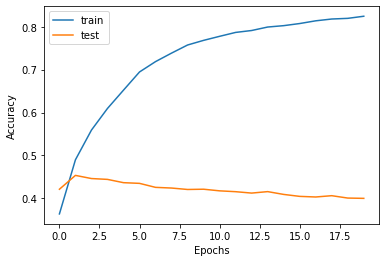

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

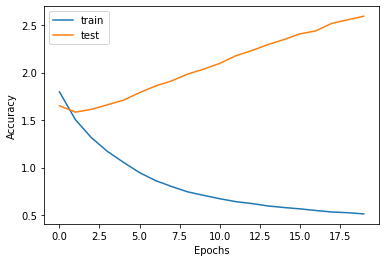

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')